In [1]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

In [2]:
def read_data(file):
    filepaths = glob.glob("../data/tidy/" + file + "*.csv")
    df = pd.concat(map(lambda x: pd.read_csv(x, index_col=0, parse_dates=True), filepaths), sort=False)
    df.sort_index(inplace=True)
    df = df.resample("D").sum()
    return df

In [97]:
df = read_data("acetaminophen")

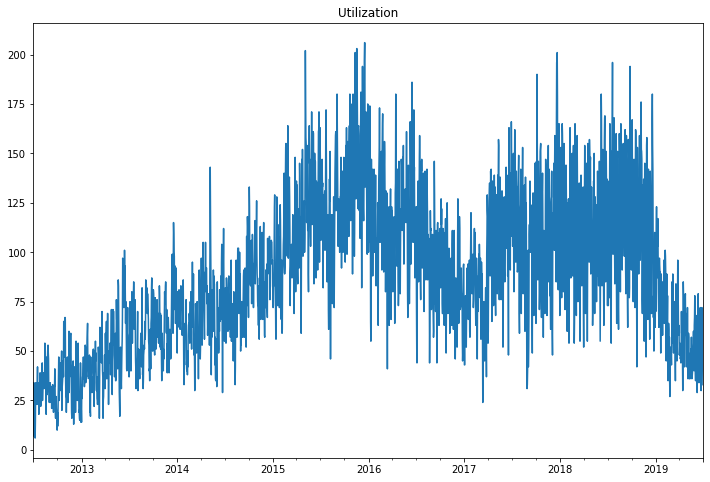

In [4]:
ax = df.plot(legend=False, figsize=(12, 8), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

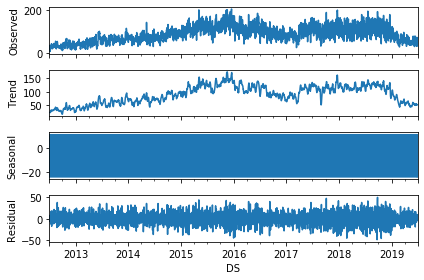

In [16]:
seasonal_decompose(df, model="add").plot();

# ACF and PACF

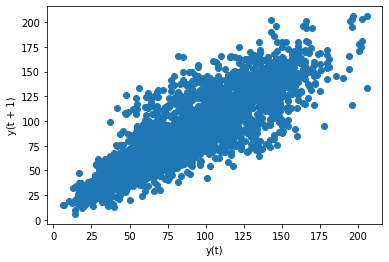

In [5]:
lag_plot(df["Y"]);

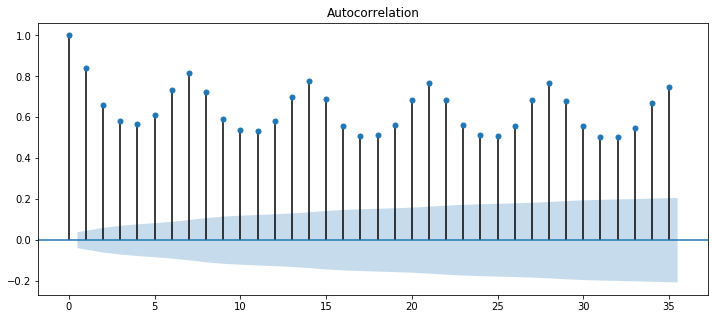

In [6]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df["Y"], ax=ax);

In [7]:
# data is not stationary if p-value > 0.05
adfuller(df["Y"].dropna(), autolag='AIC')[1]

0.225481412871869

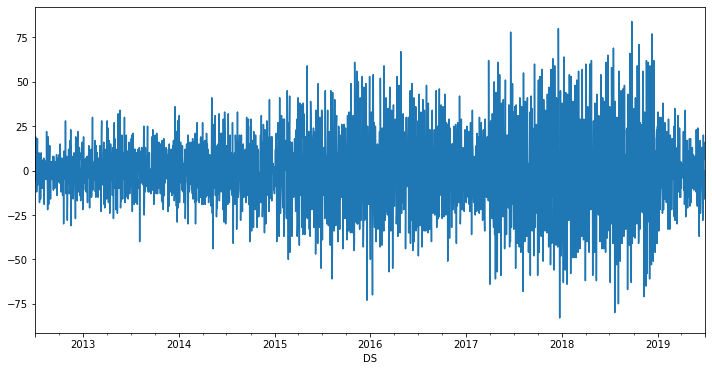

In [98]:
df_diff = df.copy()
df_diff["Y"] = diff(df_diff["Y"], k_diff=1)
df_diff.dropna(axis=0, inplace=True)
df_diff["Y"].plot(figsize=(12, 6))

In [37]:
adfuller(df_diff["Y"].dropna(), autolag='AIC')[1]

8.930716935088746e-28

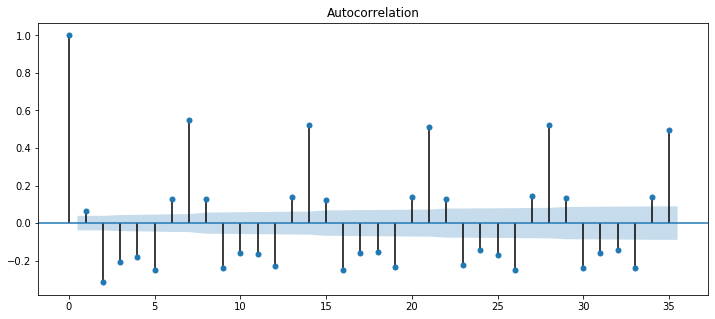

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_diff["Y"].dropna(), ax=ax);

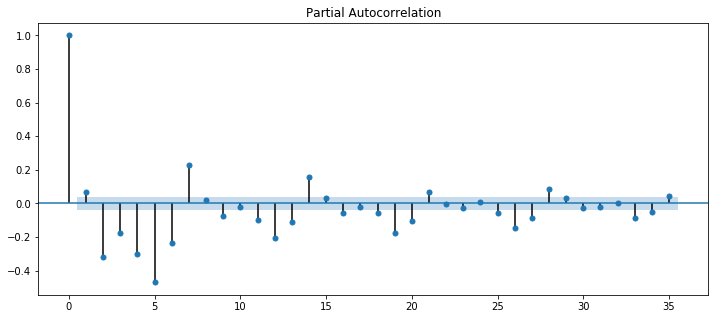

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Y"].dropna(), ax=ax);

# Train-Test-Split

In [99]:
n_pred = 90
l = len(df) - n_pred
df_train = df.iloc[:l]
df_test = df.iloc[l:]
df_diff_train = df_diff.iloc[:l]
df_diff_test = df_diff.iloc[l:]

# AR Model

In [100]:
model_ar = AR(df_train["Y"], missing="drop")
fit_ar = model_ar.fit(method="cmle")
max_lags = fit_ar.k_ar
print(f'Lag: {max_lags}')

Lag: 27


In [120]:
preds_ar = fit_ar.predict(start=len(df_diff_train), end=len(df_diff), dynamic=False)#.rename('AR Predictions')

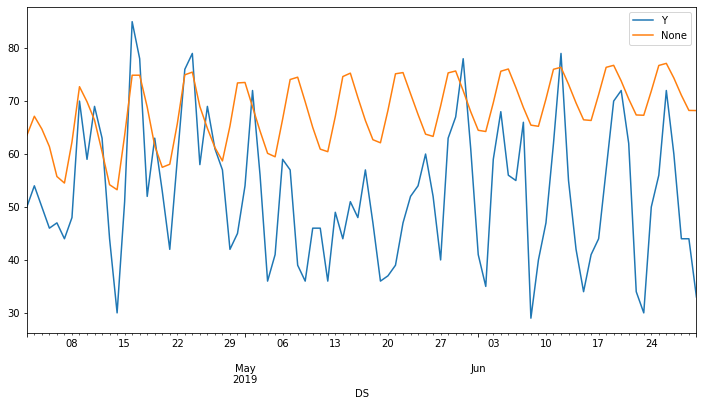

In [122]:
df_test["Y"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

In [123]:
print(f'MSE: {mean_squared_error(df_test["Y"], preds_ar):11.10}')
print(f'RMSE: {rmse(df_test["Y"], preds_ar):11.10}')
print(f'AIC: {fit_ar.aic:6.5}')

MSE:   369.75133
RMSE: 19.22891911
AIC: 5.4391


# AR Model (Differenced)

In [111]:
model_ar_d = AR(df_diff_train["Y"], missing="drop")
fit_ar_d = model_ar_d.fit(method="cmle")
max_lags_d = fit_ar_d.k_ar
print(f'Lag: {max_lags_d}')

Lag: 27


In [112]:
preds_ar_d = fit_ar_d.predict(start=len(df_diff_train)-1, end=len(df_diff) - 1, dynamic=False)#.rename('AR Predictions')

In [113]:
preds_ar_inv = pd.DataFrame(df_train["Y"].iloc[-1] + preds_ar_d.cumsum(), columns=["Preds"])

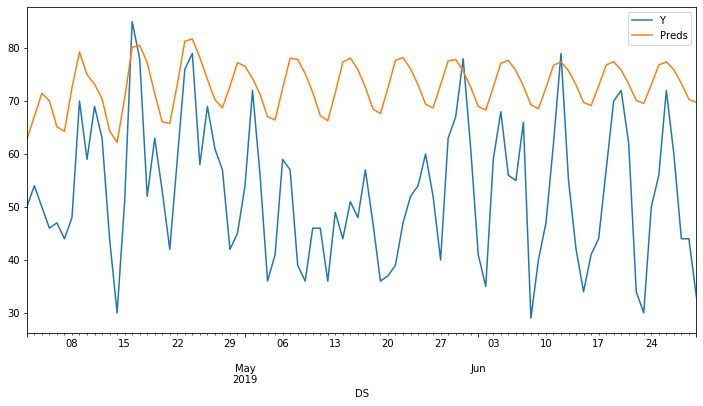

In [114]:
df_test["Y"].plot(legend=True)
preds_ar_inv["Preds"].plot(legend=True, figsize=(12, 6));

In [115]:
print(f'MSE: {mean_squared_error(df_test["Y"], preds_ar_inv["Preds"]):11.10}')
print(f'RMSE: {rmse(df_test["Y"], preds_ar_inv["Preds"]):11.10}')
print(f'AIC: {fit_ar.aic:6.5}')

MSE: 524.0264828
RMSE: 22.89162473
AIC: 5.4391


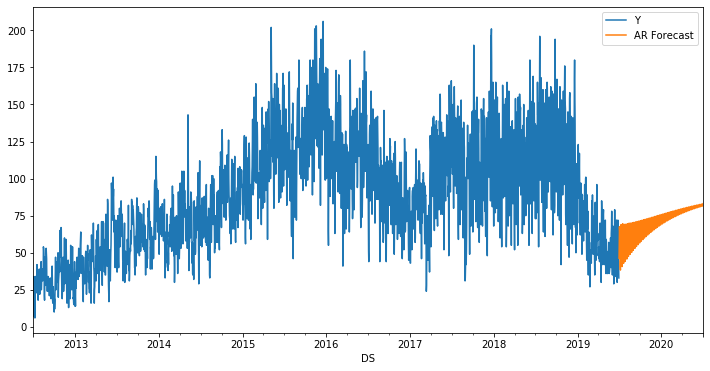

In [70]:
model_ar = AR(df["Y"])
fit_ar = model_ar.fit(maxlag=max_lags, method="cmle")
preds_ar = fit_ar.predict(start=len(df), end=len(df) + 366, dynamic=False).rename('AR Forecast')
df["Y"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

In [45]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [50]:
arma_order_select_ic(df_diff["Y"], max_ar=6, max_ma=6)

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'bic':               0             1             2             3             4  \
 0  23024.301782  23005.217238  22289.182877  22177.365601  22175.943150   
 1  23021.004269  22505.047106  22210.951967  22180.494842  22163.684533   
 2  22749.643635  22124.737676  22101.415270  21846.245001  21504.195945   
 3  22674.488229  22126.548338  22109.031551  22100.764687  21511.539362   
 4  22437.234423  22005.802270  21622.210730  21566.094280  21387.099652   
 5  21808.409203  21743.231760  21618.174286  21480.934194  21312.854152   
 6  21668.126634  21596.435312  21524.963738  21415.590531  21250.215178   
 
               5             6  
 0  22161.362560  22168.185982  
 1  22167.577297  22156.457854  
 2  21511.587851  21518.838700  
 3  21519.767914  21527.222603  
 4  21253.403746  21081.972671  
 5  20977.180364  20983.604412  
 6  20983.509034  20989.387442  , 'bic_min_order': (5, 5)}

# ARIMA Model

In [146]:
# import itertools

# p = q = range(0, 7)
# d = range(1, 2)
# pdq = list(itertools.product(p, d, q))

# for param in pdq:
#     try:
#         mod = ARIMA(df["Y"], order=param)
#         results = mod.fit()
#         print('ARIMA{}: AIC = {}'.format(param, results.aic))
#     except:
#         print('ARIMA{}: Could not fit'.format(param))
#         continue

In [124]:
auto_mod = auto_arima(
    df["Y"], 
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    max_order=10,
    seasonal=False, 
    stepwise=False,
    suppress_warnings=True,
    error_action="ignore",
    trace=False,
    out_of_sample_size=60
)

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 5); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


In [125]:
auto_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2555
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -10441.667
Method:                       css-mle   S.D. of innovations             14.384
Date:                Fri, 12 Jul 2019   AIC                          20907.334
Time:                        19:01:08   BIC                          20977.484
Sample:                             1   HQIC                         20932.773
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126      0.036      0.347      0.729      -0.059       0.084
ar.L1.D.y      1.3996      0.021     66.672      0.000       1.358       1.441
ar.L2.D.y     -1.9224      0.017   -113.511      0.000      -1.956      -1.889
ar.L3.D.y      1.6638      0.030     54.948      0.000       1.604       1.723
ar.L4.D.y     -1.4763      0.017    -87.864      0.000      -1.509      -1.443
ar.L5.D.y      0.5974      0.021     28.719      0.000       0.557       0.638
ma.L1.D.y     -1.7299      0.012   -145.450      0.000      -1.753      -1.707
ma.L2.D.y      2.1357      0.016    136.696      0.000       2.105       2.166
ma.L3.D.y     -2.0860      0.019   -112.341      0.000      -2.122      -2.050
ma.L4.D.y      1.6615      0.014    116.717      0.000       1.634       1.689
ma.L5.D.y     -0.8877      0.010    -84.818      0.000      -0.908      -0.867
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2229           -0.9755j            1.0007           -0.2857
AR.2           -0.2229           +0.9755j            1.0007            0.2857
AR.3            0.6237           -0.7825j            1.0007           -0.1429
AR.4            0.6237           +0.7825j            1.0007            0.1429
AR.5            1.6695           -0.0000j            1.6695           -0.0000
MA.1           -0.2274           -0.9883j            1.0141           -0.2860
MA.2           -0.2274           +0.9883j            1.0141            0.2860
MA.3            1.0554           -0.0000j            1.0554           -0.0000
MA.4            0.6355           -0.7963j            1.0188           -0.1428
MA.5            0.6355           +0.7963j            1.0188            0.1428
-----------------------------------------------------------------------------
"""

In [144]:
# x = auto_mod.order
x = (5, 1, 2)
model_arima = ARIMA(df_train["Y"], order=x)
fit_arima = model_arima.fit()

In [147]:
fc, se, conf = fit_arima.forecast(90, alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

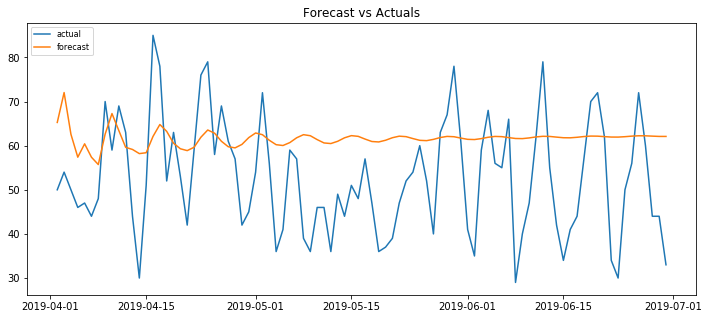

In [148]:
plt.figure(figsize=(12, 5))
#plt.plot(train_set, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [149]:
print(f'MSE: {mean_squared_error(df_test["Y"], fc_series):11.10}')
print(f'RMSE: {rmse(df_test["Y"], fc_series):11.10}')

MSE: 236.1628048
RMSE: 15.36758943


In [142]:
# x = auto_mod.order
x = (5, 1, 2)
model_arima = ARIMA(df["Y"], order=x)
fit_arima = model_arima.fit()
n_pred = 366
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
idx = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_pred, freq="D")
fc_series = pd.Series(fc, index=idx)
lower_series = pd.Series(conf[:, 0], index=idx)
upper_series = pd.Series(conf[:, 1], index=idx)

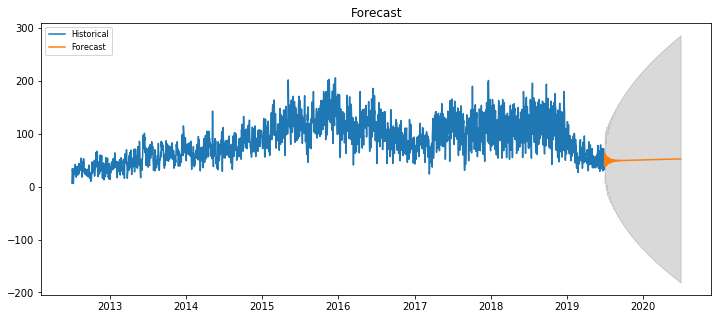

In [143]:
plt.figure(figsize=(12, 5))
plt.plot(df, label='Historical')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# ARIMA Transformed

In [126]:
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [127]:
pt = PowerTransformer()
tf = pt.fit_transform(df)
print(pt.lambdas_)

[0.61607787]


In [129]:
df_tf = pd.DataFrame(tf, columns=["Y"])
df_tf.index = df.index
am_tf = auto_mod = auto_arima(
    df_tf["Y"], 
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    max_order=10,
    seasonal=False, 
    stepwise=False,
    suppress_warnings=True,
    error_action="ignore",
    trace=False,
    out_of_sample_size=60
)

In [130]:
am_tf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 2555
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1021.408
Method:                       css-mle   S.D. of innovations              0.360
Date:                Fri, 12 Jul 2019   AIC                           2066.815
Time:                        19:15:30   BIC                           2136.965
Sample:                             1   HQIC                          2092.255
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.399      0.690      -0.001       0.002
ar.L1.D.y      1.4061      0.021     68.276      0.000       1.366       1.446
ar.L2.D.y     -1.9280      0.017   -116.121      0.000      -1.961      -1.895
ar.L3.D.y      1.6738      0.030     56.313      0.000       1.616       1.732
ar.L4.D.y     -1.4825      0.016    -89.947      0.000      -1.515      -1.450
ar.L5.D.y      0.6043      0.020     29.550      0.000       0.564       0.644
ma.L1.D.y     -1.7345      0.011   -154.656      0.000      -1.756      -1.713
ma.L2.D.y      2.1484      0.015    147.579      0.000       2.120       2.177
ma.L3.D.y     -2.1009      0.018   -119.908      0.000      -2.135      -2.067
ma.L4.D.y      1.6778      0.013    127.123      0.000       1.652       1.704
ma.L5.D.y     -0.8998      0.010    -88.953      0.000      -0.920      -0.880
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2229           -0.9753j            1.0004           -0.2858
AR.2           -0.2229           +0.9753j            1.0004            0.2858
AR.3            0.6236           -0.7824j            1.0005           -0.1429
AR.4            0.6236           +0.7824j            1.0005            0.1429
AR.5            1.6517           -0.0000j            1.6517           -0.0000
MA.1           -0.2269           -0.9863j            1.0121           -0.2860
MA.2           -0.2269           +0.9863j            1.0121            0.2860
MA.3            1.0534           -0.0000j            1.0534           -0.0000
MA.4            0.6325           -0.7937j            1.0149           -0.1429
MA.5            0.6325           +0.7937j            1.0149            0.1429
-----------------------------------------------------------------------------
"""

In [131]:
model_arima_tf = ARIMA(df_tf["Y"], order=am_tf.order)
fit_arima_tf = model_arima_tf.fit()
fc, se, conf = fit_arima_tf.forecast(366, alpha=0.05)  # 95% conf
idx = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = 366, freq="D")
df_fc = pd.DataFrame(fc, index=idx)
fc_tf = pt.inverse_transform(df_fc)
df_fc_tf = pd.DataFrame(fc_tf, columns=["Preds"])
df_fc_tf.index = idx

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


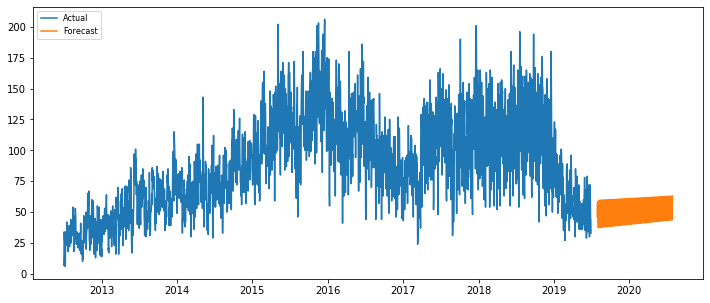

In [132]:
plt.figure(figsize=(12, 5))
plt.plot(df, label='Actual')
plt.plot(df_fc_tf, label='Forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
# plt.title('Acetaminophen Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [133]:
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.functions import SignatureTranslatedFunction
pandas2ri.activate()

In [134]:
forecast = importr('forecast')
forecast.auto_arima = SignatureTranslatedFunction(forecast.auto_arima, init_prm_translate = {'lambda_': 'lambda'})

In [136]:
f = forecast.auto_arima(df["Y"], 
                        max_order=10, 
                        stepwise=False, 
                        approximation=False, 
                        lambda_="auto", 
                        biasadj=True)
fc = forecast.forecast(f, h = 366)

In [137]:
fcst = fc.rx2("mean")
fc_series = pd.DataFrame(fcst, columns=["Forecast"], index=idx)

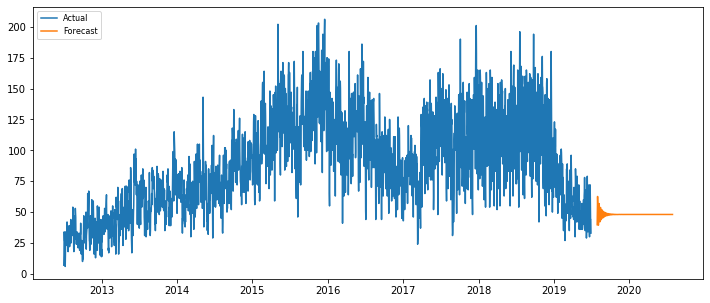

In [139]:
plt.figure(figsize=(12, 5))
plt.plot(df, label='Actual')
plt.plot(fc_series, label='Forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
# plt.title('Acetaminophen Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [151]:
df_m = df.resample("MS").sum()

In [160]:
f_m = forecast.auto_arima(df_m["Y"], 
                        max_order=10, 
                        stepwise=False, 
                        approximation=False, 
                        lambda_="auto", 
                        biasadj=True)
fc_m = forecast.forecast(f_m, h = 12)

In [171]:
forecast.summary_Arima(f_m)

Series: c("2012-07-01 00:00:00" = 833L, "2012-08-01 00:00:00" = 1124L,  "2012-09-01 00:00:00" = 786L, "2012-10-01 00:00:00" = 1229L,  "2012-11-01 00:00:00" = 1112L, "2012-12-01 00:00:00" = 1016L,  "2013-01-01 00:00:00" = 1268L, "2013-02-01 00:00:00" = 1021L,  "2013-03-01 00:00:00" = 1251L, "2013-04-01 00:00:00" = 1450L,  "2013-05-01 00:00:00" = 1609L, "2013-06-01 00:00:00" = 1963L,  "2013-07-01 00:00:00" = 1809L, "2013-08-01 00:00:00" = 1516L,  "2013-09-01 00:00:00" = 1904L, "2013-10-01 00:00:00" = 2008L,  "2013-11-01 00:00:00" = 1772L, "2013-12-01 00:00:00" = 2294L,  "2014-01-01 00:00:00" = 2033L, "2014-02-01 00:00:00" = 1690L,  "2014-03-01 00:00:00" = 1870L, "2014-04-01 00:00:00" = 2378L,  "2014-05-01 00:00:00" = 2199L, "2014-06-01 00:00:00" = 2077L,  "2014-07-01 00:00:00" = 2201L, "2014-08-01 00:00:00" = 2255L,  "2014-09-01 00:00:00" = 2280L, "2014-10-01 00:00:00" = 3065L,  "2014-11-01 00:00:00" = 2506L, "2014-12-01 00:00:00" = 2822L,  "2015-01-01 00:00:00" = 2879L, "2015-02-01 00:0

array([[ 2.56889639e+00,  3.40703306e+02,  2.63675395e+02,
        -6.10193673e-01,  1.10049016e+01,  9.87147395e-01,
        -8.05351668e-02]])

In [161]:
idx_m = pd.date_range(df_m.index[-1] + pd.DateOffset(months=1), periods = 12, freq="MS")
df_fc_m = pd.DataFrame(fc_m.rx2("mean"), columns=["Forecast"], index=idx_m)

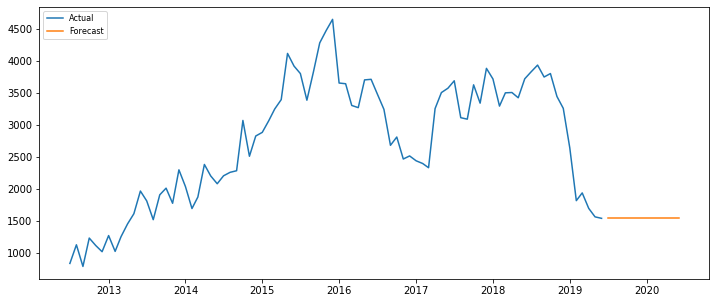

In [162]:
plt.figure(figsize=(12, 5))
plt.plot(df_m, label='Actual')
plt.plot(df_fc_m, label='Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [165]:
am_m = auto_arima(
    df_m["Y"], 
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    max_order=10,
    seasonal=False, 
    stepwise=False,
    suppress_warnings=True,
    error_action="ignore",
    trace=True,
    out_of_sample_size=3
)

Fit ARIMA: order=(0, 1, 0); AIC=1208.608, BIC=1213.446, Fit time=0.022 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1210.139, BIC=1217.396, Fit time=0.083 seconds
Fit ARIMA: order=(0, 1, 2); AIC=1211.822, BIC=1221.498, Fit time=0.072 seconds
Fit ARIMA: order=(0, 1, 3); AIC=1213.823, BIC=1225.917, Fit time=0.125 seconds
Fit ARIMA: order=(0, 1, 4); AIC=1209.654, BIC=1224.167, Fit time=0.285 seconds
Fit ARIMA: order=(0, 1, 5); AIC=1210.736, BIC=1227.667, Fit time=0.406 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1210.098, BIC=1217.355, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 1); AIC=1212.066, BIC=1221.741, Fit time=0.172 seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0); AIC=1211.992, BIC=1221.667, Fit time=0.095 seconds
Fit ARIMA: order=(2, 

In [164]:
am_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   83
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -592.849
Method:                       css-mle   S.D. of innovations            290.996
Date:                Fri, 12 Jul 2019   AIC                           1207.698
Time:                        19:42:48   BIC                           1234.305
Sample:                             1   HQIC                          1218.387
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.4443     31.982      0.452      0.653     -48.239      77.128
ar.L1.D.y      0.3233      0.125      2.579      0.012       0.078       0.569
ar.L2.D.y     -1.3112      0.079    -16.634      0.000      -1.466      -1.157
ar.L3.D.y      0.1888      0.164      1.148      0.255      -0.134       0.511
ar.L4.D.y     -0.8089      0.084     -9.685      0.000      -0.973      -0.645
ar.L5.D.y     -0.1213      0.119     -1.017      0.313      -0.355       0.112
ma.L1.D.y     -0.4607      0.071     -6.513      0.000      -0.599      -0.322
ma.L2.D.y      1.6434      0.089     18.540      0.000       1.470       1.817
ma.L3.D.y     -0.4607      0.086     -5.376      0.000      -0.629      -0.293
ma.L4.D.y      0.9999      0.096     10.369      0.000       0.811       1.189
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5007           -0.8877j            1.0192           -0.1683
AR.2            0.5007           +0.8877j            1.0192            0.1683
AR.3           -0.2791           -1.0188j            1.0564           -0.2926
AR.4           -0.2791           +1.0188j            1.0564            0.2926
AR.5           -7.1120           -0.0000j            7.1120           -0.5000
MA.1            0.4352           -0.9004j            1.0000           -0.1783
MA.2            0.4352           +0.9004j            1.0000            0.1783
MA.3           -0.2048           -0.9788j            1.0000           -0.2828
MA.4           -0.2048           +0.9788j            1.0000            0.2828
-----------------------------------------------------------------------------
"""

In [173]:
# x = am_m.order
x = (0, 1, 0)
model_arima_m = ARIMA(df_m["Y"], order=x)
fit_arima_m = model_arima_m.fit()

In [174]:
fc, se, conf = fit_arima_m.forecast(12, alpha=0.05)  # 95% conf

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [170]:
idx = pd.date_range(df_m.index[-1] + pd.DateOffset(months=1), periods = 12, freq="MS")
fc_series = pd.Series(fc, index=idx)
lower_series = pd.Series(conf[:, 0], index=idx)
upper_series = pd.Series(conf[:, 1], index=idx)

TypeError: Cannot cast ufunc subtract output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df, label='Historical')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()